# mTSP (multiple travel salesman problem)

In [20]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import random # To generate distinct colors

class MTSP_Optimization:
    """
    Modelo mTSP usando Pyomo con restricciones de eliminación de subtours (MTZ).

    Resuelve el Problema de los Múltiples Viajantes de Comercio (mTSP) donde 'm'
    viajantes deben visitar 'n' ciudades comenzando y terminando en un depósito
    (nodo 0), minimizando la distancia total.

    Attributes:
        cost_matrix (list of lists): Matriz de costos (n+1 x n+1), donde el índice 0 es el depósito.
        num_salesmen (int): Número de viajantes (m).
        num_nodes (int): Número total de nodos (n+1).
        num_cities (int): Número de ciudades (n).
        model (pyo.ConcreteModel): El modelo Pyomo construido.
        solver_name (str): Nombre del solver a usar (por defecto 'cbc').
    """

    def __init__(self, cost_matrix, num_salesmen, solver_name='glpk'):
        """
        Inicializa la instancia de optimización mTSP.

        Args:
            cost_matrix (list of lists): Matriz de costos incluyendo el depósito en el índice 0.
                                        Debe ser de tamaño (n+1) x (n+1).
            num_salesmen (int): El número de viajantes (m).
            solver_name (str): Nombre del solver Pyomo a utilizar (ej. 'cbc', 'glpk', 'gurobi', 'cplex').
        """
        if not cost_matrix or not cost_matrix[0]:
            raise ValueError("La matriz de costos no puede estar vacía.")
        if len(cost_matrix) != len(cost_matrix[0]):
             raise ValueError("La matriz de costos debe ser cuadrada.")
        if num_salesmen <= 0:
            raise ValueError("Debe haber al menos un viajante.")

        self.cost_matrix = cost_matrix
        self.num_salesmen = num_salesmen
        self.num_nodes = len(cost_matrix) # n+1 (incluye depósito)
        self.num_cities = self.num_nodes - 1 # n
        self.solver_name = solver_name
        self.model = None # Se creará en el método model()

        if self.num_cities == 0:
            print("Advertencia: No hay ciudades para visitar (solo el depósito).")


    def build_model(self):
        """Construye el modelo matemático mTSP en Pyomo."""
        self.model = pyo.ConcreteModel(name="mTSP")

        # --- SETS ---
        # Nodos: 0 (depósito), 1..n (ciudades)
        self.model.N = pyo.RangeSet(0, self.num_nodes - 1)
        # Ciudades: 1..n
        self.model.C = pyo.RangeSet(1, self.num_cities)
        # Viajantes: 1..m
        self.model.K = pyo.RangeSet(1, self.num_salesmen)

        # --- PARAMETERS ---
        # Costo de ir de i a j
        def cost_init(model, i, j):
            # Asegurarse de que los índices coincidan con la matriz 0-based
            if i == j:
                return 1e9 # Costo muy alto para evitar bucles i -> i
            return self.cost_matrix[i][j]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        # --- VARIABLES ---
        # x[i, j, k] = 1 si el viajante k va de i a j, 0 si no
        self.model.x = pyo.Var(self.model.N, self.model.N, self.model.K, within=pyo.Binary)
        # u[i, k] = variable auxiliar para eliminación de subtours (MTZ)
        # Representa la posición de la ciudad i en la ruta del viajante k
        # Solo se define para las ciudades (no el depósito)
        self.model.u = pyo.Var(self.model.C, self.model.K, within=pyo.NonNegativeReals, bounds=(1, self.num_cities))

        # --- OBJECTIVE FUNCTION ---
        # Minimizar el costo total de todos los viajantes
        def _objective_rule(model):
            return sum(model.c[i, j] * model.x[i, j, k]
                       for k in model.K
                       for i in model.N
                       for j in model.N if i != j)
        self.model.objective = pyo.Objective(rule=_objective_rule, sense=pyo.minimize)

        # --- CONSTRAINTS ---
        # 1. Cada ciudad es visitada exactamente una vez por algún viajante
        def _visit_once_rule(model, j):
             # j es una ciudad (pertenece a C)
            return sum(model.x[i, j, k] for k in model.K for i in model.N if i != j) == 1
        self.model.visit_once = pyo.Constraint(self.model.C, rule=_visit_once_rule)

        # 2. Cada viajante sale del depósito (nodo 0) una vez
        def _leave_depot_rule(model, k):
            return sum(model.x[0, j, k] for j in model.C) == 1 # Sale hacia una ciudad
        self.model.leave_depot = pyo.Constraint(self.model.K, rule=_leave_depot_rule)

        # 3. Cada viajante regresa al depósito (nodo 0) una vez
        def _return_depot_rule(model, k):
            return sum(model.x[i, 0, k] for i in model.C) == 1 # Regresa desde una ciudad
        self.model.return_depot = pyo.Constraint(self.model.K, rule=_return_depot_rule)

        # 4. Conservación de flujo para cada viajante en cada ciudad
        def _flow_conservation_rule(model, i, k):
            # i es una ciudad (pertenece a C)
            in_flow = sum(model.x[h, i, k] for h in model.N if h != i)
            out_flow = sum(model.x[i, j, k] for j in model.N if j != i)
            return in_flow == out_flow
        self.model.flow_conservation = pyo.Constraint(self.model.C, self.model.K, rule=_flow_conservation_rule)

        # 5. Eliminación de Subtours (MTZ)
        # Solo aplica entre ciudades (i, j in C)
        def _subtour_elimination_rule(model, i, j, k):
            if i != j and i in model.C and j in model.C:
                 # Si x[i,j,k] = 1, entonces u[j,k] >= u[i,k] + 1
                 # Reescribiendo: u[i,k] - u[j,k] + n*x[i,j,k] <= n-1
                 # donde n es el número de ciudades
                return model.u[i, k] - model.u[j, k] + self.num_cities * model.x[i, j, k] <= self.num_cities - 1
            else:
                # No se aplica si i=j, o si i o j es el depósito (0)
                return pyo.Constraint.Skip
        self.model.subtour_elimination = pyo.Constraint(self.model.N, self.model.N, self.model.K, rule=_subtour_elimination_rule)

        # Restricción adicional: No viajar del nodo i al nodo i
        def _no_self_loops(model, i, k):
            return model.x[i, i, k] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, self.model.K, rule=_no_self_loops)

        print("Modelo mTSP construido exitosamente.")

    def print_model_structure(self):
        """Imprime la estructura del modelo Pyomo."""
        if self.model:
            self.model.pprint()
        else:
            print("El modelo no ha sido construido todavía. Llama a build_model() primero.")

    def solve_model(self, tee=True, time_limit=None):
        """
        Resuelve el modelo mTSP construido.

        Args:
            tee (bool): Si es True, muestra la salida del solver en la consola.
            time_limit (int, optional): Límite de tiempo en segundos para el solver.

        Returns:
            pyomo.opt.results.SolverResults: Objeto con los resultados de la optimización.
                                             Retorna None si el modelo no existe o la solución no es óptima/factible.
        """
        if not self.model:
            print("Error: El modelo no ha sido construido. Llama a build_model() primero.")
            return None

        solver = pyo.SolverFactory(self.solver_name)
        if time_limit:
             # La forma de establecer el límite de tiempo varía según el solver
             # Intentos comunes:
            try:
                 solver.options['timelimit'] = time_limit # Para Gurobi, CPLEX
            except: pass
            try:
                solver.options['seconds'] = time_limit # Para CBC, GLPK
            except: pass
            try: # Otra forma para algunos solvers
                solver.options['TimeLimit'] = time_limit
            except: pass

        print(f"Resolviendo el modelo con {self.solver_name}...")
        results = solver.solve(self.model, tee=tee)

        # Verificar el estado de la solución
        print("\n--- Resultados de la Solución ---")
        print(f"Estado del Solver: {results.solver.status}")
        print(f"Condición de Terminación: {results.solver.termination_condition}")

        if results.solver.termination_condition == pyo.TerminationCondition.optimal or \
           results.solver.termination_condition == pyo.TerminationCondition.feasible:
             print(f"Valor Óptimo/Factible Encontrado: {pyo.value(self.model.objective):.4f}")
             return results
        else:
             print("No se encontró una solución óptima o factible.")
             print(f"Mensaje del Solver: {results.solver.message}")
             return None


    def visualize_solution(self, node_positions=None):
        """
        Visualiza las rutas encontradas para cada viajante.

        Args:
            node_positions (dict, optional): Un diccionario {nodo: (x, y)} para las posiciones
                                              de los nodos en el gráfico. Si es None, se usa
                                              nx.spring_layout().
        """
        #if not self.model or pyo.value(self.model.objective, exception_when_infeasible=False) is None:
        #    print("No hay solución válida para visualizar.")
        #    return

        # Extraer las rutas de la solución
        routes = {k: [] for k in self.model.K}
        for k in self.model.K:
            for i in self.model.N:
                for j in self.model.N:
                    if i != j and pyo.value(self.model.x[i, j, k]) > 0.5:
                        routes[k].append((i, j))

        # Crear el grafo
        G = nx.DiGraph()
        all_nodes = list(self.model.N)
        G.add_nodes_from(all_nodes)

        # Generar colores distintos para cada ruta
        # colors = plt.cm.get_cmap('plasma', self.num_salesmen) # 'tab10', 'viridis', 'plasma'
        colors = plt.get_cmap('tab10')

        plt.figure(figsize=(5, 4))

        # Definir posiciones de los nodos
        if node_positions:
            pos = node_positions
        else:
            # Usar un layout circular para separar mejor inicialmente
            # Colocar el depósito (0) en el centro puede ser mejor
            pos = nx.circular_layout(G)
            if 0 in pos:
                 # Intentar mover el nodo 0 al centro (0,0)
                 pos[0] = (0,0)
                 # Reescalar otros nodos si es necesario (esto es básico)
                 max_coord = 0
                 for node, (x,y) in pos.items():
                      if node != 0:
                           max_coord = max(max_coord, abs(x), abs(y))
                 if max_coord > 0:
                     scale = 1.0 / max_coord # Escala para que estén dentro de -1, 1
                     for node, (x,y) in pos.items():
                          if node != 0:
                             pos[node] = (x*scale, y*scale)


        # Dibujar nodos (distinguir depósito)
        node_colors = ['red' if node == 0 else 'lightblue' for node in G.nodes()]
        node_sizes = [600 if node == 0 else 300 for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)

        # Dibujar etiquetas de nodos
        nx.draw_networkx_labels(G, pos, font_size=10)

        # Dibujar arcos (rutas) con colores diferentes por viajante
        print("\nRutas encontradas:")
        for k in self.model.K:
            route_edges = routes[k]
            if not route_edges: # Si un viajante no se usa (si se permite < m)
                 continue
            edge_color = colors(k - 1) # Colores indexados desde 0
            nx.draw_networkx_edges(G, pos, edgelist=route_edges, edge_color=[edge_color]*len(route_edges),
                                   width=1.5, arrowsize=15, connectionstyle='arc3,rad=0.1')
            # Imprimir la ruta para este viajante
            current_node = 0
            path_str = "Viajante {}: 0".format(k)
            visited_count = 0
            max_steps = self.num_cities + 1 # Evitar bucles infinitos si algo falló
            while visited_count < max_steps:
                 found_next = False
                 for i, j in route_edges:
                      if i == current_node:
                           path_str += f" -> {j}"
                           current_node = j
                           visited_count += (j != 0) # Contar solo ciudades visitadas
                           found_next = True
                           break
                 if current_node == 0 or not found_next:
                     break # Regresó al depósito o no encontró siguiente
            print(path_str)


        plt.title(f"Solución mTSP con {self.num_salesmen} Viajantes (Costo Total: {pyo.value(self.model.objective):.2f})")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

Modelo mTSP construido exitosamente.
Resolviendo el modelo con glpk...

--- Resultados de la Solución ---
Estado del Solver: ok
Condición de Terminación: optimal
Valor Óptimo/Factible Encontrado: 85.0000

Rutas encontradas:
Viajante 1: 0 -> 2 -> 4 -> 3 -> 0
Viajante 2: 0 -> 1 -> 0


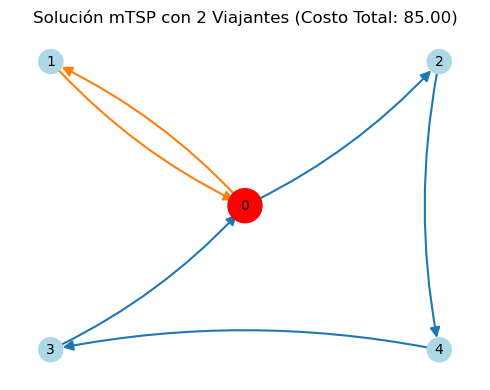

In [21]:
# Ejemplo: 1 depósito (0) y 4 ciudades (1, 2, 3, 4)
# Matriz de costos (simétrica para simplificar, incluyendo depósito)
#       0    1    2    3    4   (Nodos)
cost_matrix = [
    [ 0,  10, 15, 20, 25], # 0 (Depósito)
    [10,  0,  35, 25, 30], # 1
    [15, 35,  0,  30, 20], # 2
    [20, 25, 30,  0,  10], # 3
    [25, 30, 20, 10,  0]  # 4
]
num_salesmen = 2 # Número de viajantes a usar

# (Opcional) Definir posiciones para una visualización más clara
node_positions = {
    0: (0, 0),   # Depósito en el centro
    1: (-1, 1),
    2: (1, 1),
    3: (-1, -1),
    4: (1, -1)
}

# Crear instancia de la optimización
# Usar 'cbc' (gratuito, usualmente instalado con conda/pip pyomo)
# Otros solvers pueden requerir instalación y licencias (gurobi, cplex)
mtsp_problem = MTSP_Optimization(cost_matrix, num_salesmen)

# Construir el modelo
mtsp_problem.build_model()

# (Opcional) Imprimir la estructura del modelo para verificar
# mtsp_problem.print_model_structure()

# Resolver el modelo
results = mtsp_problem.solve_model(tee=False) # tee=False para menos salida del solver

# Visualizar la solución si se encontró una
if results:
    mtsp_problem.visualize_solution(node_positions=node_positions)


--- Ejemplo Mayor ---
Modelo mTSP construido exitosamente.
Resolviendo el modelo con glpk...

--- Resultados de la Solución ---
Estado del Solver: ok
Condición de Terminación: optimal
Valor Óptimo/Factible Encontrado: 237.0000

Rutas encontradas:
Viajante 1: 0 -> 2 -> 5 -> 4 -> 6 -> 1 -> 7 -> 0
Viajante 2: 0 -> 8 -> 0
Viajante 3: 0 -> 3 -> 0


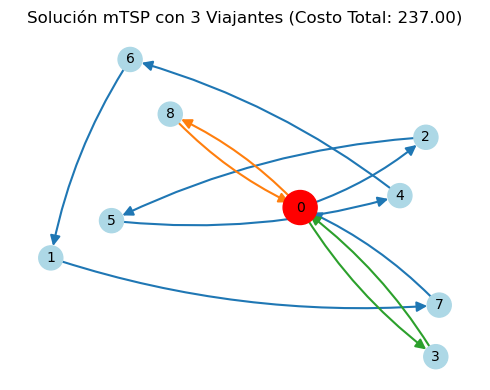

In [24]:
# Ejemplo con más ciudades y viajantes
print("\n--- Ejemplo Mayor ---")
random.seed(42) # Para reproducibilidad
num_cities_large = 8
num_salesmen_large = 3
size = num_cities_large + 1
large_cost_matrix = [[random.randint(10, 100) if i != j else 0 for j in range(size)] for i in range(size)]
# Hacerla simétrica y asegurar costo alto para i->i en el modelo
for i in range(size):
    for j in range(i + 1, size):
         large_cost_matrix[j][i] = large_cost_matrix[i][j]

# Coordenadas aleatorias para visualización
large_node_positions = {i: (random.random(), random.random()) for i in range(size)}
large_node_positions[0] = (0.5, 0.5) # Depósito en el centro

mtsp_large = MTSP_Optimization(large_cost_matrix, num_salesmen_large)
mtsp_large.build_model()
results_large = mtsp_large.solve_model(tee=False) # Límite de tiempo 60s

if results_large:
    mtsp_large.visualize_solution(node_positions=large_node_positions)

# Travel salesman problem with subtours elimination (MTZ)

In [27]:
import numpy as np
import csv

def read_cost_matrix_csv(filename):
    """
    Reads a cost matrix from a CSV file and returns it as a numpy array.
    
    The first row of the CSV is assumed to contain the node IDs.
    
    Parameters:
        filename (str): Name of the input CSV file.
    
    Returns:
        numpy.ndarray: The cost matrix read from the file.
    """
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Read the first row to get the node IDs.
        node_ids = next(reader)
        # Read the remaining rows as data.
        data = list(reader)
    
    # Convert the data to a numpy array.
    cost_matrix = np.array(data, dtype=int)
    
    return cost_matrix

In [25]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt

class Optimization:
    """
    A basic TSP model for a single driver (one route) without subtour elimination.
    It uses a cost matrix to define travel costs between cities and ensures that
    each city is visited exactly once (inbound=1, outbound=1) but does NOT include
    additional constraints to prevent subtours.

    Attributes:
        cost_matrix (list of lists): 2D matrix of travel costs between cities.
        num_cities (int): Number of cities (inferred from cost_matrix).
        model (pyo.ConcreteModel): The Pyomo model built in `model()`.

    Methods:
        model(): Builds the Pyomo model with variables, objective, and constraints.
        print_model(): Prints the Pyomo model structure.
        solve_model(): Solves the model using the 'appsi_highs' solver (by default).
        print_output(): Prints/plots the resulting route(s) as a directed graph.
    """

    def __init__(self, cost_matrix):
        self.cost_matrix = cost_matrix
        self.num_cities = len(cost_matrix)  # infer number of cities from matrix size

    def model(self):
        # Create ConcreteModel
        self.model = pyo.ConcreteModel()

        # Set of cities
        self.model.N = pyo.RangeSet(1, self.num_cities)

        # Decision variables x[i, j] = 1 if we travel from city i to city j
        self.model.x = pyo.Var(self.model.N, self.model.N, within=pyo.Binary)

        # # Auxiliary variable u[i] to enforce subtour elimination
        self.model.u = pyo.Var(self.model.N, within=pyo.NonNegativeIntegers, bounds=(1, self.num_cities - 1))

        # Cost parameter from cost_matrix
        def cost_init(model, i, j):
            return self.cost_matrix[i - 1][j - 1]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        # Objective function: minimize total travel cost
        def _objective_function(model):
            return sum(model.x[i, j] * model.c[i, j]
                       for i in model.N for j in model.N)
        self.model.objective = pyo.Objective(rule=_objective_function,
                                             sense=pyo.minimize)

        # Constraint: each city has exactly one outbound arc
        def _outbound_rule(model, i):
            return sum(model.x[i, j] for j in model.N if j != i) == 1
        self.model.outbound = pyo.Constraint(self.model.N, rule=_outbound_rule)

        # Constraint: each city has exactly one inbound arc
        def _inbound_rule(model, j):
            return sum(model.x[i, j] for i in model.N if i != j) == 1
        self.model.inbound = pyo.Constraint(self.model.N, rule=_inbound_rule)

        # No self-loops: x[i, i] = 0
        def _no_self_loops(model, i):
            return model.x[i, i] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, rule=_no_self_loops)

        # Subtour elimination constraints
        def _subtour_elimination(model, i, j):
            if i != j and i != 1 and j != 1:
                return model.u[i] - model.u[j] + self.num_cities * model.x[i, j] <= self.num_cities - 1
            else:
                return pyo.Constraint.Skip

        self.model.subtour_elimination = pyo.Constraint(self.model.N, self.model.N, rule=_subtour_elimination)

    def print_model(self):
        """Prints the model structure."""
        self.model.pprint()

    def solve_model(self):
        """Solves the TSP model using the 'appsi_highs' solver."""
        solver = pyo.SolverFactory('appsi_highs')
        solver.options['parallel'] = 'on'
        solver.options['time_limit'] = 20 * 60
        solver.options['presolve'] = 'on'
        result = solver.solve(self.model, tee=False)
        print(result)

    def print_output(self):
        """
        Plots the solution as a directed graph using NetworkX and matplotlib.
        Since there's only one route (single driver), all edges are colored the same.
        """
        valid_edges = []
        for i in self.model.N:
            for j in self.model.N:
                if pyo.value(self.model.x[i, j]) > 0.5:
                    valid_edges.append((i, j))

        # Build a directed graph
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        # Add edges from the solution
        for (i, j) in valid_edges:
            G.add_edge(i, j)

        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos, with_labels=True,
                         node_color='lightblue',
                         edge_color='red',
                         arrows=True)
        plt.axis("off")
        plt.show()


In [28]:
cost_matrix = read_cost_matrix_csv('cost_matrix_20_nodes_1.5_spread.csv')

opt = Optimization(cost_matrix)
opt.model()
opt.solve_model()

FileNotFoundError: [Errno 2] No such file or directory: 'cost_matrix_20_nodes_1.5_spread.csv'

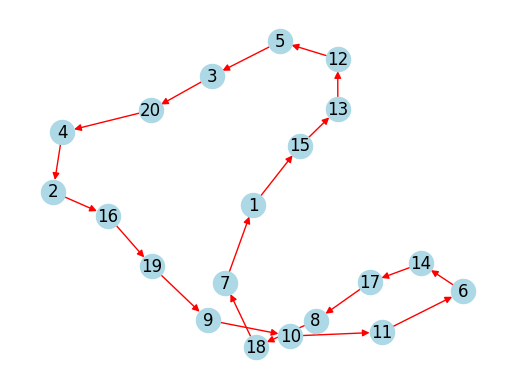

In [4]:
opt.print_output()